In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import shapefile as shp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot

In [2]:
wis_shp = '/InfoGroup/rural/map_files/tracts/tl_2017_55_tract.shp'
wis_gdf = gpd.read_file(wis_shp,crs={'init':'epsg:4326'})
# By default, census shapefiles are in the Geographic - GCS North American NAD83 projection.
# Changing it, as above, doesn't seem to make any difference.

In [3]:
wis_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [4]:
wis_gdf.dtypes

STATEFP     object
COUNTYFP    object
TRACTCE     object
GEOID       object
NAME        object
NAMELSAD    object
MTFCC       object
FUNCSTAT    object
ALAND        int64
AWATER       int64
INTPTLAT    object
INTPTLON    object
geometry    object
dtype: object

In [5]:
wis_gdf['FULL_TRACT_ID'] = wis_gdf['STATEFP']+wis_gdf['COUNTYFP']+wis_gdf['TRACTCE']
wis_gdf = wis_gdf[['FULL_TRACT_ID','COUNTYFP','geometry']].copy()

In [6]:
# Now add the primary RUCA score.
ruca_df = pd.read_csv('/InfoGroup/rural/data/ruca2010revised.csv',dtype=object)
ruca_df['Primary RUCA Code 2010'] = ruca_df['Primary RUCA Code 2010'].astype(int)
# Remove 'tracts' that are just lake water on the boundaries.
ruca_df = ruca_df[ruca_df['Primary RUCA Code 2010'] != 99]
ruca_df.columns

Index(['State-County FIPS Code', 'State', 'County', 'Tract',
       'Primary RUCA Code 2010', 'Secondary RUCA Code 2010',
       'Tract Population 2010', 'Land Area (square miles) 2010',
       'Population Density (per square mile) 2010'],
      dtype='object')

In [7]:
ruca_df = ruca_df[['Tract','Primary RUCA Code 2010']]
wis_tracts = wis_gdf.merge(ruca_df,left_on='FULL_TRACT_ID',right_on='Tract',how='outer',indicator=True)
wis_tracts = wis_tracts[wis_tracts['_merge']=='both'].copy()
wis_tracts.drop(columns=['FULL_TRACT_ID','_merge'],inplace=True)

In [8]:
wis_tracts.columns

Index(['COUNTYFP', 'geometry', 'Tract', 'Primary RUCA Code 2010'], dtype='object')

In [9]:
print(len(wis_tracts))
print(wis_tracts.columns)
print(type(wis_tracts))

1394
Index(['COUNTYFP', 'geometry', 'Tract', 'Primary RUCA Code 2010'], dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>


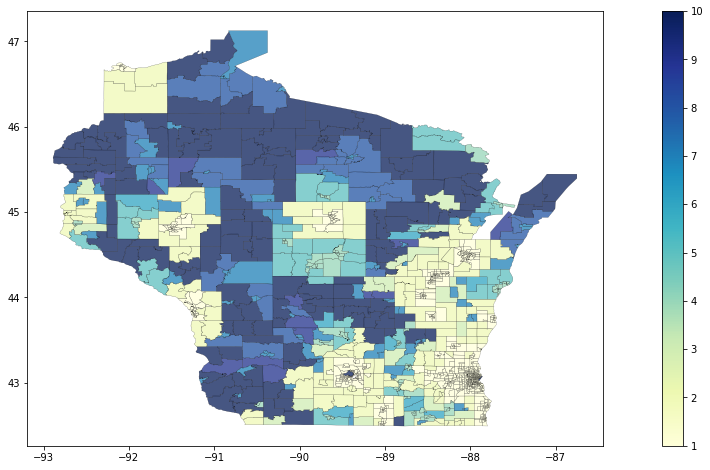

In [10]:
fig,ax = plt.subplots(figsize=(21,8))
wis_tracts.plot(column='Primary RUCA Code 2010',ax=ax,alpha=0.75,lw=0.2, \
                edgecolor='black',cmap='YlGnBu',legend=True) 

# ----------------------

In [11]:
dane_tracts = wis_tracts[wis_tracts['COUNTYFP']=='025'].copy()

In [12]:
dane_tracts['Primary RUCA Code 2010'] = dane_tracts['Primary RUCA Code 2010'].astype(int)
dane_tracts[dane_tracts['Primary RUCA Code 2010'] == 10]

,COUNTYFP,geometry,Tract,Primary RUCA Code 2010
1373,025,"POLYGON ((-89.483766 43.09381, -89.48353 43.09...",55025991702,10


In [13]:
# Lake Mendota was considered a census tract with a RUCA value of 10
dane_tracts['Tract'] = \
   dane_tracts['Tract'].apply(lambda x: np.nan if x == '55025991702' else x)

In [14]:
dane_tracts.dropna(inplace=True)

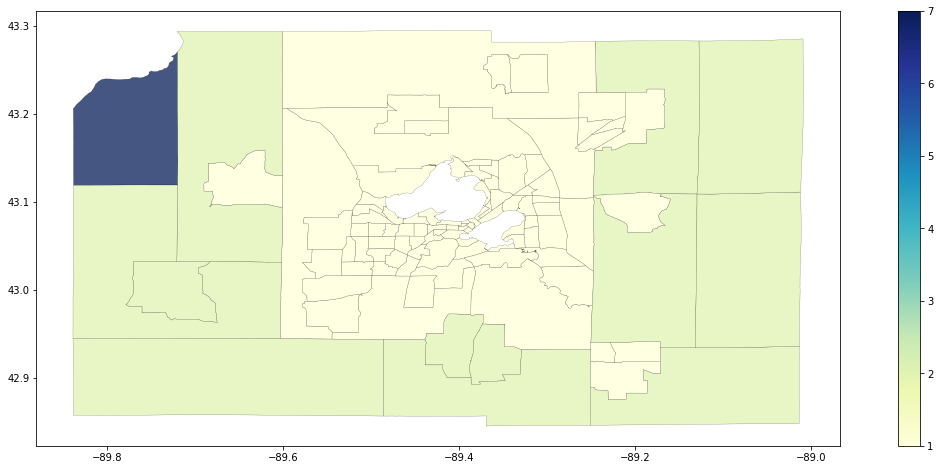

In [15]:
fig,ax = plt.subplots(figsize=(21,8))
dane_tracts.plot(column='Primary RUCA Code 2010',ax=ax,alpha=0.75,lw=0.2, \
                edgecolor='black',cmap='YlGnBu',legend=True) 

In [15]:
#in_sw = ['023','103','111','021','027','131','089','043','049','025','055','133','079','065','045','105','127','101','059']
in_sw = ['111','021','027','049','025','055','045','105']

sw_tracts = wis_tracts.loc[wis_tracts['COUNTYFP'].isin(in_sw)].copy()
sw_tracts['Primary RUCA Code 2010'] = sw_tracts['Primary RUCA Code 2010'].astype(int)

In [16]:
sw_tracts[sw_tracts['Primary RUCA Code 2010'] == 10]

,COUNTYFP,geometry,Tract,Primary RUCA Code 2010
723,049,"POLYGON ((-90.42858099999999 42.979063, -90.42...",55049950300,10
726,049,"POLYGON ((-90.26314499999999 42.861433, -90.26...",55049950600,10
773,027,"POLYGON ((-88.53130399999999 43.558786, -88.53...",55027960100,10
776,027,"POLYGON ((-88.78097799999999 43.574945, -88.78...",55027960200,10
1013,111,"POLYGON ((-90.19332199999999 43.165174, -90.19...",55111000800,10
1019,111,"POLYGON ((-90.19224899999999 43.271328, -90.19...",55111001100,10
1111,027,"POLYGON ((-89.007296 43.576028, -89.0072919999...",55027960500,10
1130,021,POLYGON ((-89.26890999999999 43.57046099999999...,55021970100,10
1234,105,"POLYGON ((-88.894583 42.494175, -88.8945179999...",55105003300,10
1373,025,"POLYGON ((-89.483766 43.09381, -89.48353 43.09...",55025991702,10


In [17]:
# Lake Mendota was considered a census tract with a RUCA value of 10
sw_tracts['Tract'] = \
   sw_tracts['Tract'].apply(lambda x: np.nan if x == '55025991702' else x)
sw_tracts.dropna(inplace=True)

In [18]:
sw_tracts.to_file('/InfoGroup/rural/map_files/sw_tracts.geojson',driver='GeoJSON')
sw_tracts.to_file('/InfoGroup/rural/map_files/sw_tracts.shp',driver='ESRI Shapefile')

In [20]:
# Get the InfoGroup enterprises for 2017 in these counties.
data_df = pd.read_csv('/InfoGroup/rural/data/df_2017.csv',dtype=object)
print(data_df.columns)
print(len(data_df))

Index(['Company', 'Address Line 1', 'City', 'State', 'ZipCode', 'County Code',
       'Primary SIC Code', 'SIC6_Descriptions', 'Primary NAICS Code',
       'NAICS8 Descriptions', 'Employee Size (5) - Location',
       'Sales Volume (9) - Location', 'Business Status Code',
       'Industry Specific First Byte', 'Year Established', 'ABI',
       'Subsidiary Number', 'Parent Number', 'Parent Actual Employee Size',
       'Parent Actual Sales Volume', 'Census Tract', 'Census Block',
       'Latitude', 'Longitude', 'CBSA Code', 'CBSA Level', 'FIPS Code',
       'State FIPS', 'Continental', 'NAICS2', 'NAICS2 desc'],
      dtype='object')
14733437


In [21]:
df = data_df[data_df['State'] == 'WI'].copy()
df_counties = df.loc[df['County Code'].isin(in_sw)].copy()
df_counties = df_counties[['ABI','Latitude','Longitude']].copy()
df_counties.head()

,ABI,Latitude,Longitude
6745225,970450078,042.621871,-088.785405
6745226,893818526,042.593374,-088.798109
6745227,707601549,042.610671,-088.785726
6765562,470373127,042.715281,-088.822250
6765563,420467261,042.826640,-088.779350


In [22]:
df_counties[['Latitude','Longitude']] = df_counties[['Latitude','Longitude']].astype(float)
geometry = [Point(xy) for xy in zip(df_counties["Longitude"],df_counties["Latitude"])]
gdf_points = gpd.GeoDataFrame(df_counties,crs={'init' :'epsg:4326'},geometry=geometry)

In [23]:
gdf_points.to_file('/InfoGroup/rural/map_files/sw_enterprises_2017.geojson',driver='GeoJSON')
gdf_points.to_file('/InfoGroup/rural/map_files/sw_enterprises_2017.shp',driver='ESRI Shapefile')

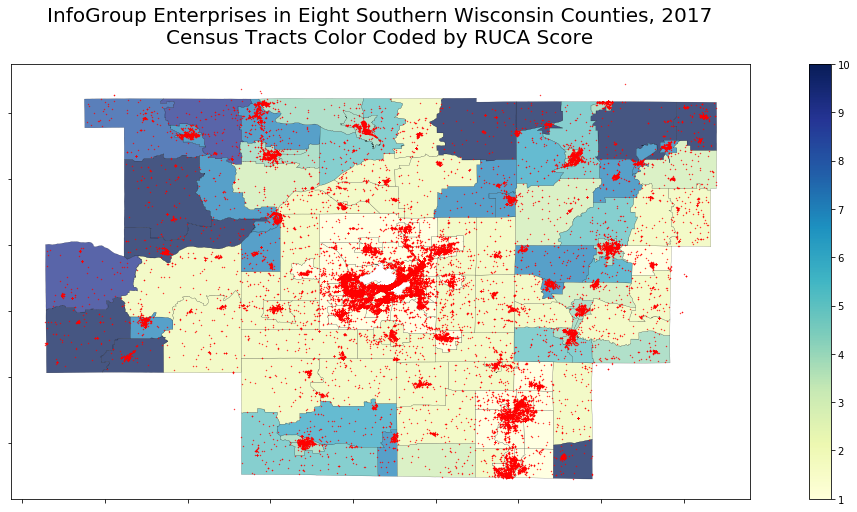

In [25]:
fig,ax = plt.subplots(figsize=(21,8))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
title = 'InfoGroup Enterprises in Eight Southern Wisconsin Counties, 2017\nCensus Tracts Color Coded by RUCA Score'
fig.suptitle(title, fontsize=20, y=0.98) # Add the text/suptitle to figure
base = sw_tracts.plot(column='Primary RUCA Code 2010',ax=ax,alpha=0.75,lw=0.2, \
                edgecolor='black',cmap='YlGnBu',legend=True)
gdf_points.plot(ax=base, marker='o', color='red', markersize=0.15)